### Import libraries and a file

In [1]:
import pandas as pd
import numpy as np
import time
import math
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("C:/Users/User/Downloads/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = df.drop(['customerID'], axis = 1)

### Encode category data

In [2]:
# Create a function to identify categorical columns
cols = df.columns.tolist()
isCat = []

def categorize(x):
    if df[col].dtype == 'category':
        catCount = df[col].unique().value_counts().sum()
        if catCount < 10:
            result = 1
        else:
            result = 0
        return result
    elif df[col].dtype == 'object':
        df[col] = df[col].astype('category')
        catCount = df[col].astype('category').unique().value_counts().sum()
        if catCount < 6:
            result = 1
        else:
            df[col] = df[col].cat.codes.astype(int)
            df[col] = df[col].astype(float)
            result = 0
        return result
    else:
        result = 0
        return result
    
# Create a list for categorical and non-categorical columns
for col in cols:
    cat_result = categorize(df[col])
    isCat.append(cat_result)
    
data = {'col':cols, 'categorical':isCat}
df_cat = pd.DataFrame(data)

# Create a list for categorical columns
catCols = df_cat[df_cat['categorical'] == 1]
col_to_dummies = catCols['col'].unique().tolist()
df = pd.get_dummies(df, columns = col_to_dummies, drop_first = True, prefix = col_to_dummies)

### Quick assess performance of each model

In [3]:
# Assess models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn import metrics

lr = LogisticRegression()
rfc = RandomForestClassifier()
dtc = DecisionTreeClassifier()
xgbc = xgb.XGBClassifier()
svc = SVC(probability = True)
models = [lr,rfc,dtc,xgbc,svc]

X = df.drop(['Churn_Yes'], axis = 1)
y = df['Churn_Yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [4]:
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model,":")
    auc = metrics.roc_auc_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    print(f"recall: {round(recall,2)}\nauc: {round(auc,2)}\n")

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression() :
recall: 0.52
auc: 0.71

RandomForestClassifier() :
recall: 0.46
auc: 0.69

DecisionTreeClassifier() :
recall: 0.48
auc: 0.65

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) :
recall: 0.5
auc: 0.69

SVC(probability=True) :
recall: 0.0
auc: 0.5



### Train a model with xgboost and rank feature importance

In [5]:
xgbc.fit(X_train, y_train)

y_pred = xgbc.predict(X_test)

# Get feature importances and sort them in descending order
importances = list(xgbc.feature_importances_)
feature_importances = [(feature, round(importance, 8)) for feature, importance in zip(X.columns, importances)]
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
# Create a list for feature importances
imp_list = []
imp_value = []
print('\033[1m' + 'Feature importance')

# Print out feature importances in descending order
for feature, importance in feature_importances:
    print('\033[0m' + f'{feature}: {round(importance,4)}')
    imp_list.append(feature)
    imp_value.append(importance)

print('\nTotal number of features:',len(imp_list))

Feature importance
InternetService_Fiber optic: 0.3659999966621399
Contract_Two year: 0.17499999701976776
Contract_One year: 0.09009999781847
InternetService_No: 0.08820000290870667
tenure: 0.03180000185966492
StreamingMovies_Yes: 0.022600000724196434
OnlineSecurity_Yes: 0.0210999995470047
MultipleLines_Yes: 0.017899999395012856
SeniorCitizen: 0.016899999231100082
PaymentMethod_Electronic check: 0.015699999406933784
PaperlessBilling_Yes: 0.014700000174343586
TechSupport_Yes: 0.014600000344216824
MonthlyCharges: 0.012799999676644802
StreamingTV_Yes: 0.012600000016391277
PhoneService_Yes: 0.012400000356137753
TotalCharges: 0.012299999594688416
OnlineBackup_Yes: 0.011599999852478504
Dependents_Yes: 0.011599999852478504
PaymentMethod_Mailed check: 0.01140000019222498
gender_Male: 0.01119999960064888
DeviceProtection_Yes: 0.010999999940395355
PaymentMethod_Credit card (automatic): 0.009999999776482582
Partner_Yes: 0.008500000461935997
MultipleLines_No phone service: 0.0
OnlineSecurity_No in

### Choose only important features to train a model and tune hyperameter

In [6]:
from datetime import datetime

start_time = datetime.now().strftime("%H:%M:%S")
start_runtime = time.time()
print('Model training starts at', start_time)

imp = imp_list[:18]
imp_value = imp_value[:18]
X = X[imp]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

params = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.05, 0.1, 0.5, 1],
    'max_depth': [3, 5, 7, 10],
    'reg_alpha': [0.5, 1, 1.5, 2],
    'reg_lambda': [0.5, 1, 1.5, 2],
}

# Perform grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgbc, param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
# Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'reg_alpha': 0.5, 'reg_lambda': 1.5}

# Train the XGBoost model with best parameters
xgbc_best = xgb.XGBClassifier(learning_rate=best_params['learning_rate'],
                              max_depth=best_params['max_depth'],
                              n_estimators=best_params['n_estimators'])

# Fit the XGBoost model on training data
xgbc_best.fit(X_train, y_train)

# Predict on test data
y_pred = xgbc_best.predict_proba(X_test)
threshold = 0.3

# Adjust the threshold and convert probabilities to class labels
y_pred = np.where(y_pred[:, 1] > threshold, 1, 0)

auc = metrics.roc_auc_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
print(f"recall: {round(recall,2)}\nauc: {round(auc,2)}\n")
print(metrics.classification_report(y_test, y_pred, target_names=[str(i) for i in np.unique(y_test)]))

end_time = datetime.now().strftime("%H:%M:%S")
end_runtime = time.time()
print('Model training ends at:', end_time)
runtime = end_runtime - start_runtime
print(f"Total runtime (Model training): \
{math.floor(runtime/60/60)} hours {round(runtime//60%60)} minutes {round(runtime - runtime//60*60)} seconds")

Model training starts at 14:57:15
recall: 0.76
auc: 0.76

              precision    recall  f1-score   support

           0       0.89      0.77      0.82      1262
           1       0.56      0.76      0.65       499

    accuracy                           0.76      1761
   macro avg       0.73      0.76      0.73      1761
weighted avg       0.80      0.76      0.77      1761

Model training ends at: 15:27:12
Total runtime (Model training): 0 hours 29 minutes 57 seconds


### Evaluate result

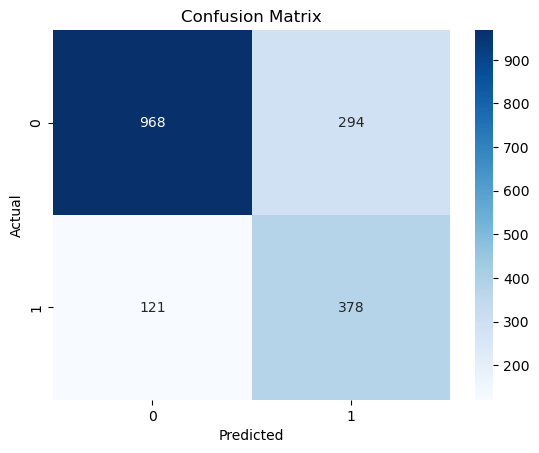

In [7]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and ticks
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

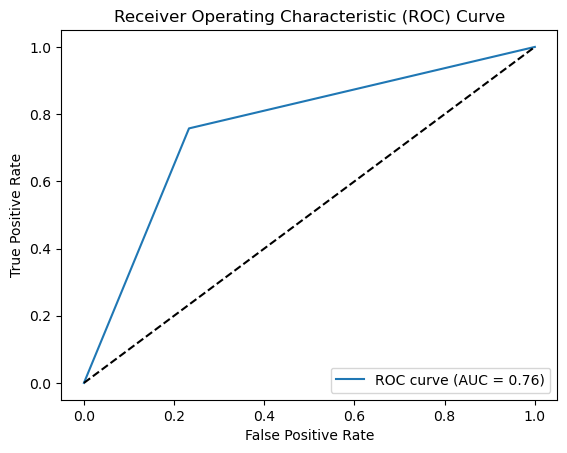

In [8]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Even though adjusting threshold can significantly improve precision and recall, the cost of losing one is too high. Hence, I decide to balance them, so we can save fairly amount of those potential churn at acceptable cost.